In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns


# Load files

In [2]:
# Load training and testing data
train_data_path = '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/'
test_data_path = '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_40min_test/'

train_accel_data = pd.read_csv(train_data_path + 'Combined_accelerometer_100min.csv')
train_gyro_data = pd.read_csv(train_data_path + 'Combined_gyroscope_100min.csv')
train_linear_accel_data = pd.read_csv(train_data_path + 'Combined_linear_accelerometer_100min.csv')
train_magnetometer_data = pd.read_csv(train_data_path + 'Combined_magnetometer_100min.csv')

test_accel_data = pd.read_csv(test_data_path + 'Combined_accelerometer_40min.csv')
test_gyro_data = pd.read_csv(test_data_path + 'Combined_gyroscope_40min.csv')
test_linear_accel_data = pd.read_csv(test_data_path + 'Combined_linear_accelerometer_40min.csv')
test_magnetometer_data = pd.read_csv(test_data_path + 'Combined_magnetometer_40min.csv')

# Combine all data into one dataframe for training and testing
combined_train_data = pd.merge(train_accel_data, train_gyro_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_train_data = pd.merge(combined_train_data, train_linear_accel_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_train_data = pd.merge(combined_train_data, train_magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))

combined_test_data = pd.merge(test_accel_data, test_gyro_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_test_data = pd.merge(combined_test_data, test_linear_accel_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_test_data = pd.merge(combined_test_data, test_magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))


In [3]:
# Pre-processed sensor data
feature_columns = combined_train_data.columns.difference(['time', 'label'])
X_train_sensor = combined_train_data[feature_columns]
y_train = combined_train_data['label']

X_test_sensor = combined_test_data[feature_columns]
y_test = combined_test_data['label']


# Sensor + Temporal Data

In [4]:
def add_temporal_features(df, lags, rolling_windows):
    for feature in df.columns:
        if feature not in ['time', 'label']:
            for lag in lags:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            for window in rolling_windows:
                df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=window).mean()
                df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=window).std()
                df[f'{feature}_ewma'] = df[feature].ewm(span=10).mean()
    df.dropna(inplace=True)
    return df

lags = [3]
rolling_windows = [5]

combined_train_data_temporal = add_temporal_features(combined_train_data.copy(), lags, rolling_windows)
combined_test_data_temporal = add_temporal_features(combined_test_data.copy(), lags, rolling_windows)

feature_columns_temporal = combined_train_data_temporal.columns.difference(['time', 'label'])
X_train_temporal = combined_train_data_temporal[feature_columns_temporal]
y_train_temporal = combined_train_data_temporal['label']

X_test_temporal = combined_test_data_temporal[feature_columns_temporal]
y_test_temporal = combined_test_data_temporal['label']


# Sensor + Fourier Transformations

In [5]:
def compute_fft_features(df, columns):
    fft_features = {}
    for col in columns:
        fft_vals = fft(df[col].values)
        fft_features[f'{col}_fft_real'] = np.real(fft_vals)
        fft_features[f'{col}_fft_imag'] = np.imag(fft_vals)
        fft_features[f'{col}_fft_abs'] = np.abs(fft_vals)
    return pd.DataFrame(fft_features)

fft_columns = combined_train_data.columns.difference(['time', 'label'])
fft_train_data = compute_fft_features(combined_train_data, fft_columns)
fft_test_data = compute_fft_features(combined_test_data, fft_columns)

feature_columns_fft = fft_train_data.columns
X_train_fft = fft_train_data
y_train_fft = combined_train_data['label']  # Same labels

X_test_fft = fft_test_data
y_test_fft = combined_test_data['label']  # Same labels


In [6]:
# Sensor + Temporal Features
X_train_sensor_temporal = pd.concat([X_train_sensor, X_train_temporal], axis=1).dropna()
X_test_sensor_temporal = pd.concat([X_test_sensor, X_test_temporal], axis=1).dropna()

y_train_sensor_temporal = y_train.loc[X_train_sensor_temporal.index]
y_test_sensor_temporal = y_test.loc[X_test_sensor_temporal.index]

# Sensor + Fourier Transformations
X_train_sensor_fft = pd.concat([X_train_sensor, X_train_fft], axis=1).dropna()
X_test_sensor_fft = pd.concat([X_test_sensor, X_test_fft], axis=1).dropna()

y_train_sensor_fft = y_train.loc[X_train_sensor_fft.index]
y_test_sensor_fft = y_test.loc[X_test_sensor_fft.index]

# Train/Test

In [7]:
# Train/Test
def plot_feature_importance(rf_model, feature_columns, title):
    feature_importances = rf_model.feature_importances_
    feature_names = feature_columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [8]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, model_params, feature_columns, title):
    rf_model = RandomForestClassifier(**model_params)
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['clapping', 'handshake', 'highfive', 'wave'])
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    
    # Plot feature importance
    plot_feature_importance(rf_model, feature_columns, title)
    
    return rf_model


In [9]:
model_params = {
    'n_estimators': 9,
    'max_depth': 19,
    'min_samples_split': 3,
    'min_samples_leaf': 7,
    'criterion': 'log_loss',
    'max_features': 'log2',
    'random_state': 24
}

Model 1: Pre-processed Sensor Data
Accuracy: 0.4865
Confusion Matrix:
[[564 589   4  33]
 [734 293  77  93]
 [ 47  91 805 251]
 [390  56  83 657]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.33      0.47      0.39      1190
   handshake       0.28      0.24      0.26      1197
    highfive       0.83      0.67      0.74      1194
        wave       0.64      0.55      0.59      1186

    accuracy                           0.49      4767
   macro avg       0.52      0.49      0.50      4767
weighted avg       0.52      0.49      0.50      4767



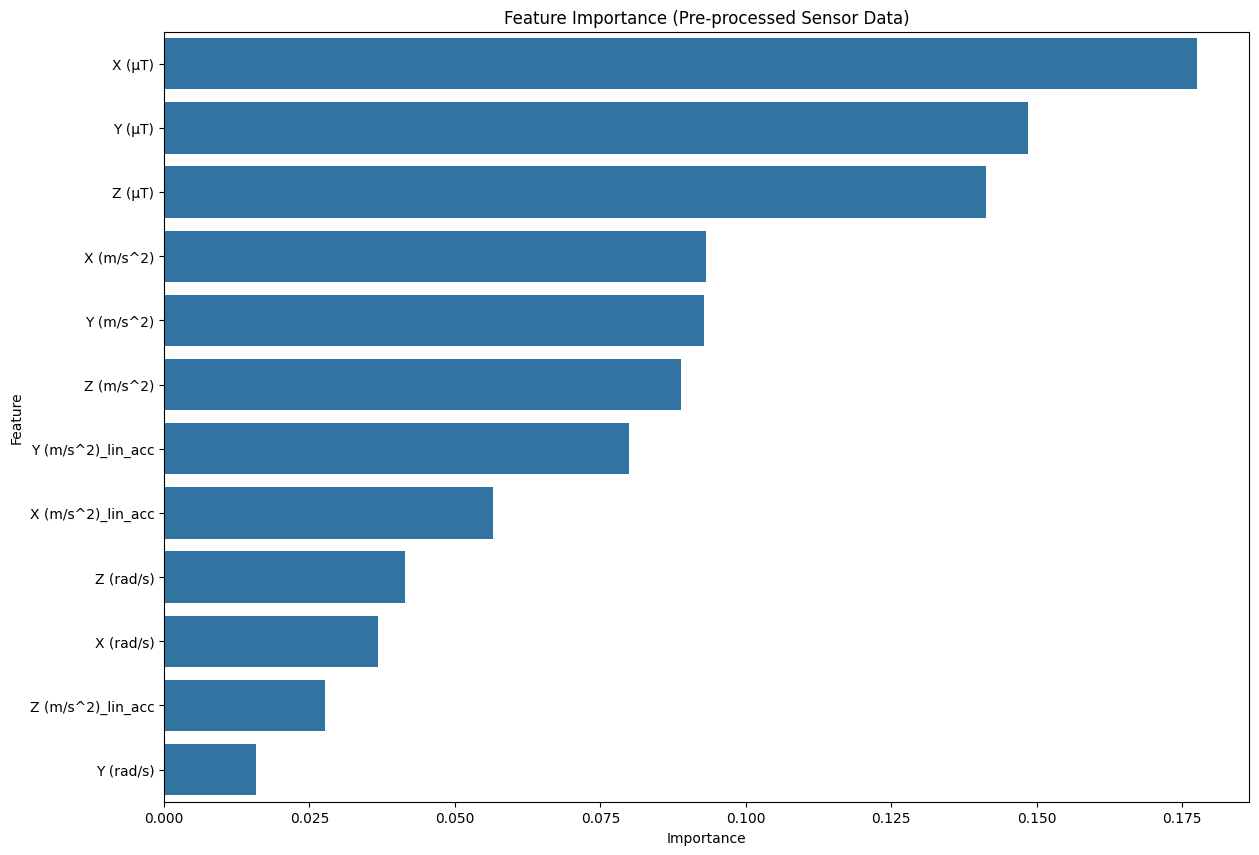

Model 2: Temporal Features Only
Accuracy: 0.7928
Confusion Matrix:
[[1152   35    3    0]
 [ 247  826  116    4]
 [   1    5 1134   54]
 [ 517    1    4  664]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.60      0.97      0.74      1190
   handshake       0.95      0.69      0.80      1193
    highfive       0.90      0.95      0.93      1194
        wave       0.92      0.56      0.70      1186

    accuracy                           0.79      4763
   macro avg       0.84      0.79      0.79      4763
weighted avg       0.84      0.79      0.79      4763



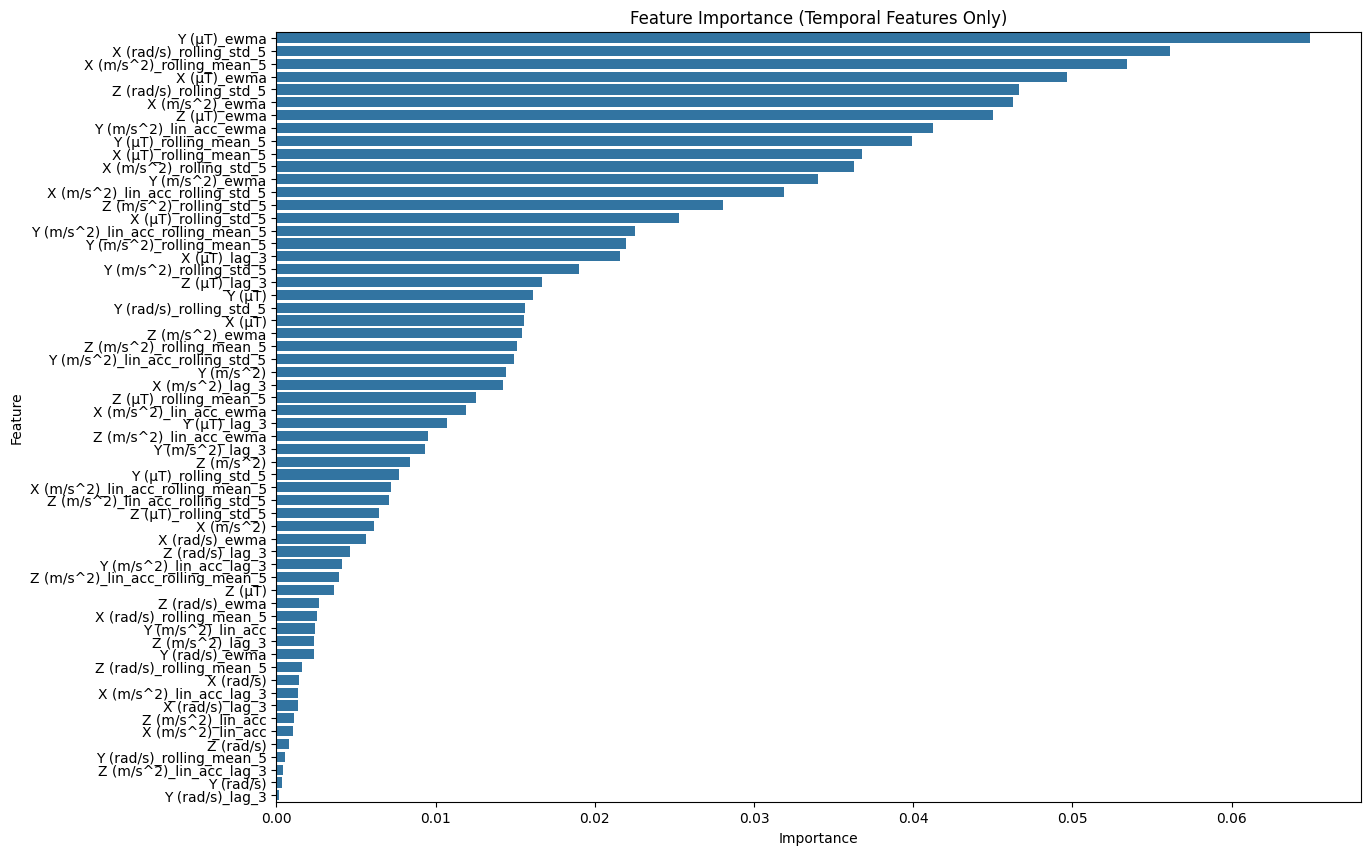

Model 3: Fourier Transformation Only
Accuracy: 0.3707
Confusion Matrix:
[[286 556 140 208]
 [  7 729   3 458]
 [279 520 157 238]
 [  5 586   0 595]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.50      0.24      0.32      1190
   handshake       0.30      0.61      0.41      1197
    highfive       0.52      0.13      0.21      1194
        wave       0.40      0.50      0.44      1186

    accuracy                           0.37      4767
   macro avg       0.43      0.37      0.35      4767
weighted avg       0.43      0.37      0.35      4767



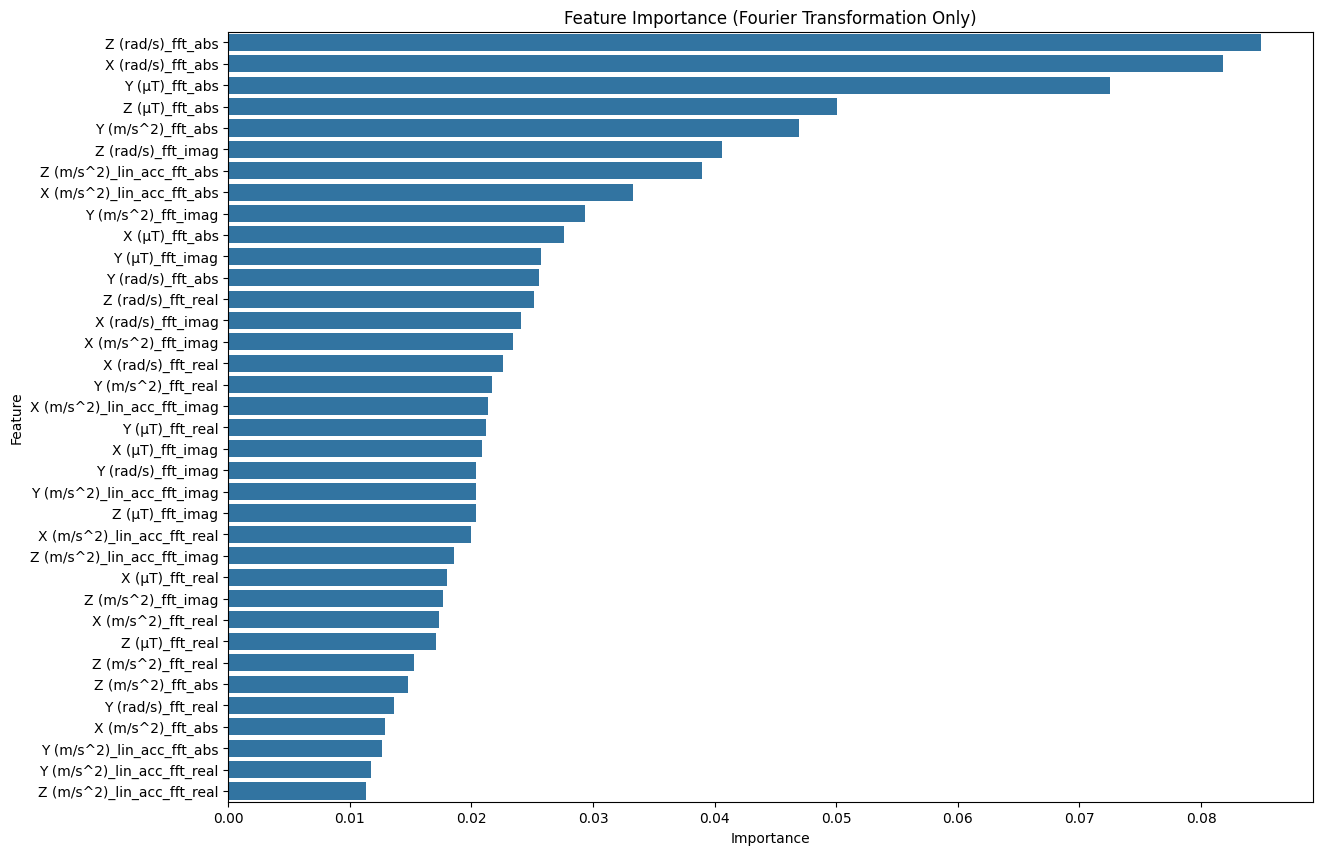

Model 4: Sensor + Temporal Features
Accuracy: 0.7382
Confusion Matrix:
[[1091   96    3    0]
 [ 582  520   91    0]
 [   1    0 1129   64]
 [ 403    0    7  776]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.53      0.92      0.67      1190
   handshake       0.84      0.44      0.57      1193
    highfive       0.92      0.95      0.93      1194
        wave       0.92      0.65      0.77      1186

    accuracy                           0.74      4763
   macro avg       0.80      0.74      0.74      4763
weighted avg       0.80      0.74      0.74      4763



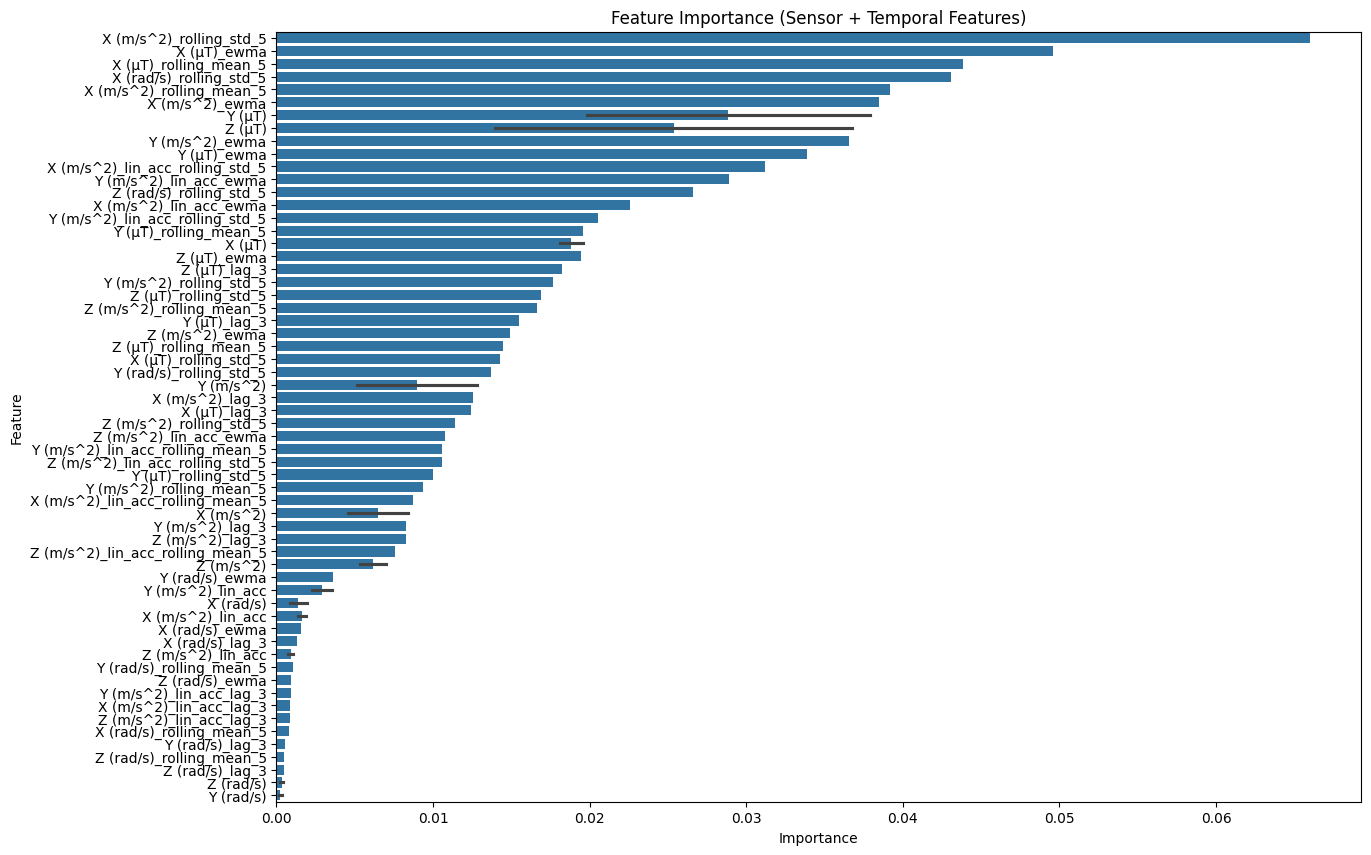

Model 5: Sensor + Fourier Transformations
Accuracy: 0.5305
Confusion Matrix:
[[642 479  33  36]
 [579 447  63 108]
 [ 95 116 608 375]
 [315  34   5 832]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.39      0.54      0.46      1190
   handshake       0.42      0.37      0.39      1197
    highfive       0.86      0.51      0.64      1194
        wave       0.62      0.70      0.66      1186

    accuracy                           0.53      4767
   macro avg       0.57      0.53      0.54      4767
weighted avg       0.57      0.53      0.54      4767



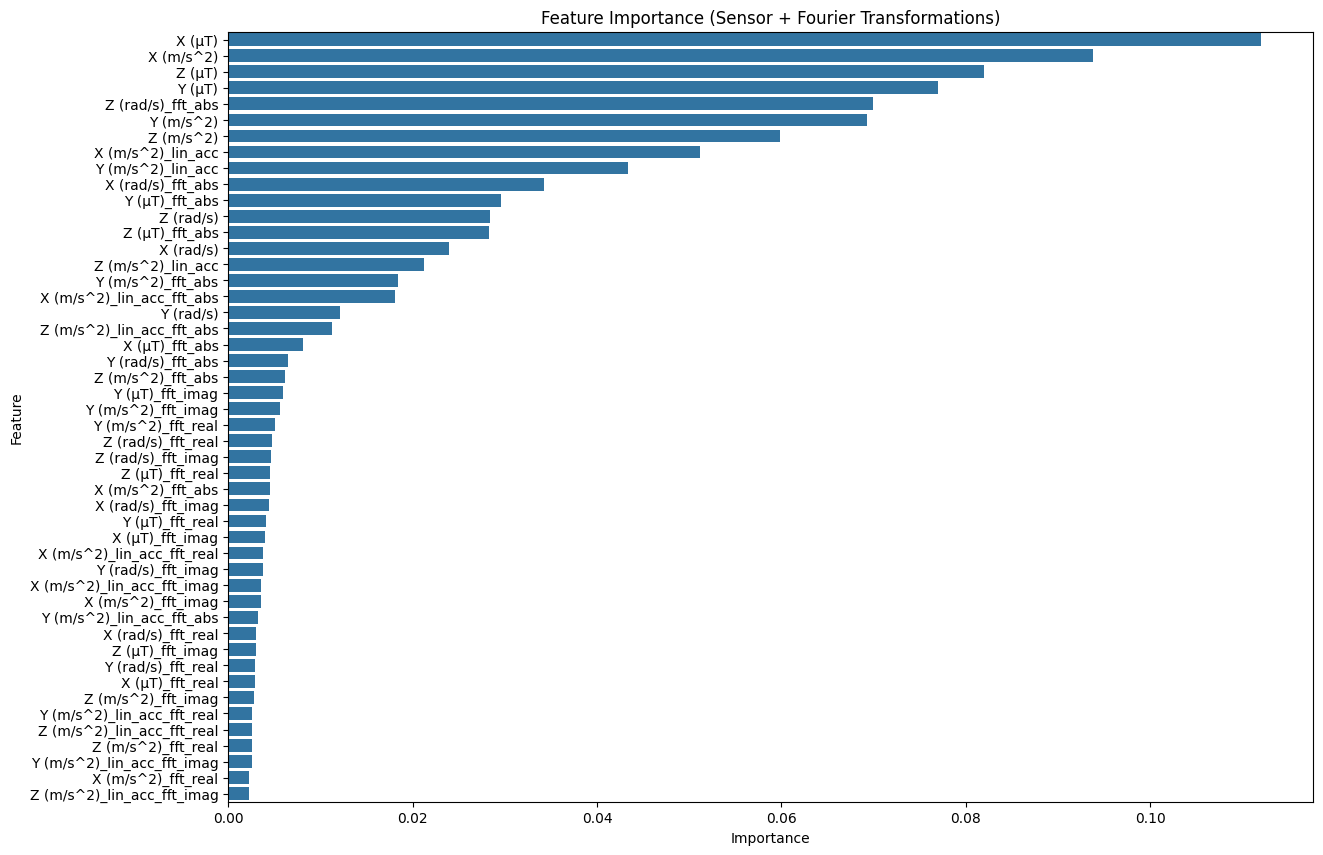

In [10]:

# Model 1: Pre-processed Sensor Data
print("Model 1: Pre-processed Sensor Data")
rf_model_sensor = train_and_evaluate_rf(X_train_sensor, y_train, X_test_sensor, y_test, model_params, feature_columns, "Feature Importance (Pre-processed Sensor Data)")

# Model 2: Temporal Features Only
print("Model 2: Temporal Features Only")
rf_model_temporal_only = train_and_evaluate_rf(X_train_temporal, y_train_temporal, X_test_temporal, y_test_temporal, model_params, feature_columns_temporal, "Feature Importance (Temporal Features Only)")

# Model 3: Fourier Transformation Only
print("Model 3: Fourier Transformation Only")
rf_model_fft_only = train_and_evaluate_rf(X_train_fft, y_train_fft, X_test_fft, y_test_fft, model_params, feature_columns_fft, "Feature Importance (Fourier Transformation Only)")

# Model 4: Sensor + Temporal Features
print("Model 4: Sensor + Temporal Features")
rf_model_sensor_temporal = train_and_evaluate_rf(X_train_sensor_temporal, y_train_sensor_temporal, X_test_sensor_temporal, y_test_sensor_temporal, model_params, X_train_sensor_temporal.columns, "Feature Importance (Sensor + Temporal Features)")

# Model 5: Sensor + Fourier Transformations
print("Model 5: Sensor + Fourier Transformations")
rf_model_sensor_fft = train_and_evaluate_rf(X_train_sensor_fft, y_train_sensor_fft, X_test_sensor_fft, y_test_sensor_fft, model_params, X_train_sensor_fft.columns, "Feature Importance (Sensor + Fourier Transformations)")